In this notebook is analysis of the hyperspectral image found at './graphite-rod'. The rod was heated to 1000 C and then imaged quickly after removing from the furnace. The rod was placed perpendicular to the camera line and kept in place as the image was taken. This results in the vertical axis of the image representing time from top to bottom.

In [1]:
# imports

from spectral import imshow, view_cube
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from numpy.polynomial import Polynomial, polynomial
import time

# https://doi.org/10.1063/5.0019847 imports
import algorithm.generate_spectrum as gs
from algorithm.pixel_operations import choose_pixels, generate_combinations
from algorithm.temperature_functions import optimum_temperature
from algorithm.kfold import order_selection
from scipy.interpolate import splrep, splev, UnivariateSpline

# constants
h = 6.626e-34 # Planck's constant
c = 299792458 # Speed of light
k = 1.380649e-23 # Boltzmann constant
b = 2.89777e-3 # Wien's displacement law constant

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Opening Data

### Importing Data

In [2]:
# opening the raw data from its ENVI file and header
dark_ref = envi.open('graphite-rod/darkReference.hdr', 'graphite-rod/darkReference.raw')
white_ref = envi.open('graphite-rod/whiteReference.hdr', 'graphite-rod/whiteReference.raw')
data_ref = envi.open('graphite-rod/raw.hdr', 'graphite-rod/raw.raw')
print(type(data_ref))
print()
print(data_ref)

<class 'spectral.io.bilfile.BilFile'>

	Data Source:   './graphite-rod/raw.raw'
	# Rows:            719
	# Samples:        1600
	# Bands:           371
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16


In [3]:
# converting the data to a tensor as a NumPy array
white_tensor = np.array(white_ref.load())
dark_tensor = np.array(dark_ref.load())
data_tensor = np.array(data_ref.load())
print(type(data_tensor))
shape = data_tensor.shape
print(f"Tensor dimensions = {shape}")
print()
print(data_tensor)

<class 'numpy.ndarray'>
Tensor dimensions = (719, 1600, 371)

[[[ 374.  397.  491. ... 2258. 2244. 2355.]
  [ 374.  397.  491. ... 2255. 2140. 2115.]
  [ 409.  442.  494. ... 2282. 2251. 2087.]
  ...
  [ 121.   92.  113. ...  317.  265.  260.]
  [ 126.  124.  128. ...  243.  267.  222.]
  [ 114.  132.  120. ...  295.  275.  228.]]

 [[ 386.  447.  513. ... 2391. 2234. 2105.]
  [ 386.  447.  513. ... 2321. 2241. 2213.]
  [ 441.  473.  475. ... 2293. 2217. 2195.]
  ...
  [ 125.  127.  116. ...  276.  283.  283.]
  [ 126.  153.  125. ...  261.  292.  321.]
  [ 110.  133.  129. ...  295.  308.  265.]]

 [[ 395.  400.  539. ... 2178. 2240. 2222.]
  [ 395.  400.  539. ... 2263. 2216. 2242.]
  [ 353.  437.  453. ... 2299. 2181. 2180.]
  ...
  [ 144.  143.  118. ...  296.  317.  288.]
  [ 121.   93.  134. ...  310.  271.  243.]
  [ 101.  112.  144. ...  246.  288.  328.]]

 ...

 [[ 413.  481.  434. ... 2268. 2195. 2300.]
  [ 413.  481.  434. ... 2330. 2181. 2283.]
  [ 391.  488.  443. ... 224

/Users/namanparikh/opt/anaconda3/envs/openmsi/lib/python3.9/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


<Figure size 640x480 with 0 Axes>

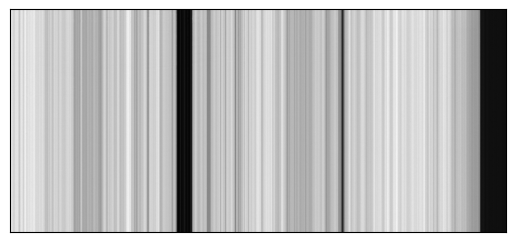

In [4]:
# correcting tensor with references and displaying tensor as an image
corrected_data = np.divide(
    np.subtract(data_tensor, dark_tensor),
    np.subtract(white_tensor, dark_tensor))
plt.figure()
imshow(corrected_data, (100,100,100))
plt.xticks([])
plt.yticks([])
plt.show()

Focusing in on the rod

<Figure size 640x480 with 0 Axes>

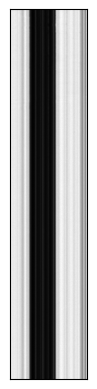

In [5]:
plt.figure()
imshow(corrected_data[:,500:650,:], (100,100,100))
plt.xticks([])
plt.yticks([])
plt.show()

<Figure size 640x480 with 0 Axes>

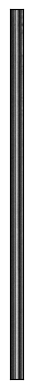

In [6]:
plt.figure()
imshow(corrected_data[:,550:575,:], (100,100,100))
plt.xticks([])
plt.yticks([])
plt.show()

## Parsing HDR for Bands

In [7]:
# reading hdr file
file = open("raw.hdr", 'r')
text = file.read()
print(text)

ENVI
description = {[HEADWALL Hyperspec III]}
samples = 1600
lines = 1562
bands = 371
header offset = 0
file type = ENVI Standard
data type = 12
interleave = bil
sensor type = Unknown
default bands = {191,86,50}
byte order = 0
wavelength units = nm
wavelength = {
399.471
,401.098
,402.725
,404.351
,405.978
,407.605
,409.232
,410.858
,412.485
,414.112
,415.738
,417.365
,418.992
,420.619
,422.245
,423.872
,425.499
,427.126
,428.752
,430.379
,432.006
,433.633
,435.259
,436.886
,438.513
,440.14
,441.766
,443.393
,445.02
,446.647
,448.273
,449.9
,451.527
,453.153
,454.78
,456.407
,458.034
,459.66
,461.287
,462.914
,464.541
,466.167
,467.794
,469.421
,471.048
,472.674
,474.301
,475.928
,477.555
,479.181
,480.808
,482.435
,484.062
,485.688
,487.315
,488.942
,490.569
,492.195
,493.822
,495.449
,497.075
,498.702
,500.329
,501.956
,503.582
,505.209
,506.836
,508.463
,510.089
,511.716
,513.343
,514.97
,516.596
,518.223
,519.85
,521.477
,523.103
,524.73
,526.357
,527.984
,529.61
,531.237
,532.864


In [8]:
# parsing for wavelength values and units

start_id = "\nwavelength = {\n"
start_index = text.find(start_id) + len(start_id)
end_id = "\n}\n;AOI height"
end_index = text.find(end_id)
wavelengths = text[start_index:end_index]
wavelengths_arr = np.array(wavelengths.split("\n,"), dtype="float32")

units_id = "wavelength units = "
units_index = text.find(units_id) + len(units_id)
units = text[units_index:text.find(start_id)]
print(f"Units = {units}")
print(f"Number wavelengths = {len(wavelengths_arr)}")
print(f"Wavelengths: {wavelengths_arr}")

Units = nm
Number wavelengths = 371
Wavelengths: [ 399.471  401.098  402.725  404.351  405.978  407.605  409.232  410.858
  412.485  414.112  415.738  417.365  418.992  420.619  422.245  423.872
  425.499  427.126  428.752  430.379  432.006  433.633  435.259  436.886
  438.513  440.14   441.766  443.393  445.02   446.647  448.273  449.9
  451.527  453.153  454.78   456.407  458.034  459.66   461.287  462.914
  464.541  466.167  467.794  469.421  471.048  472.674  474.301  475.928
  477.555  479.181  480.808  482.435  484.062  485.688  487.315  488.942
  490.569  492.195  493.822  495.449  497.075  498.702  500.329  501.956
  503.582  505.209  506.836  508.463  510.089  511.716  513.343  514.97
  516.596  518.223  519.85   521.477  523.103  524.73   526.357  527.984
  529.61   531.237  532.864  534.491  536.117  537.744  539.371  540.997
  542.624  544.251  545.878  547.504  549.131  550.758  552.385  554.011
  555.638  557.265  558.892  560.518  562.145  563.772  565.399  567.025
  568

## Loading one row

In [9]:
print(corrected_data.shape)
print(corrected_data[:,0,:].shape)
print(corrected_data[:,0,:][0].shape)

(719, 1600, 371)
(719, 371)
(371,)


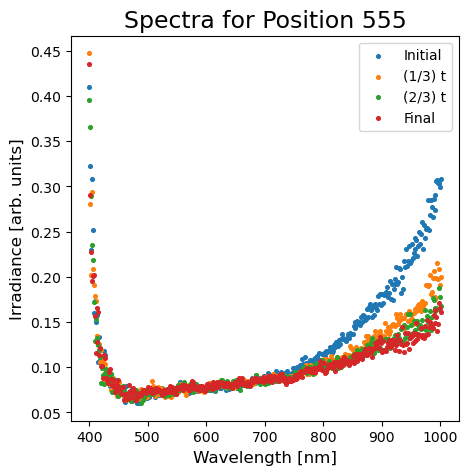

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths_arr, corrected_data[:,555,:][0], s=7)
plt.scatter(wavelengths_arr, corrected_data[:,555,:][int(len(corrected_data[:,555,:][0]) * (1/3))], s=7)
plt.scatter(wavelengths_arr, corrected_data[:,555,:][int(len(corrected_data[:,555,:][0]) * (2/3))], s=7)
plt.scatter(wavelengths_arr, corrected_data[:,555,:][-1], s=7)
plt.title("Spectra for Position 555", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.legend(["Initial", "(1/3) t", "(2/3) t", "Final"], fontsize=10)
plt.show()

The infrared radiation decreases, indicating the rod cooling. The uptick for small wavelengths is a result of very high uncertainty in the camera's measurements of those wavelengths.

### Blackbody at 700 C

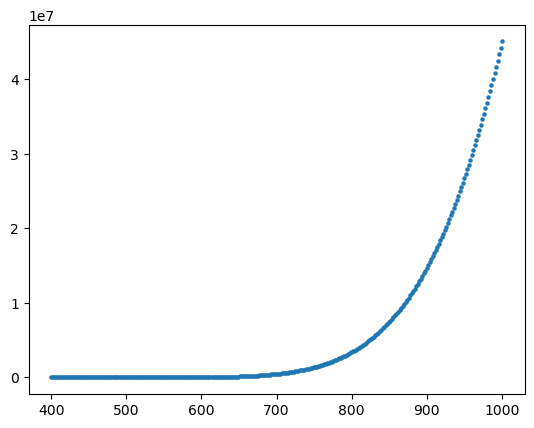

In [11]:
# l: wavelength, T: temperature, e: emissivity
def blackbody(l, T, e):
    return e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))

x = np.linspace(400e-9, 1000e-9, num=300)
y = np.array([blackbody(i, 700+273, 1) for i in x])
plt.scatter(x*1e9, y, s=5)

# Pyrometry

## Least Squares Regression
For this, we need to assume some model of emissivity's wavelength dependence. Using the second-degree polynomial mentioned above, we can model emissivity with $$\epsilon(\lambda) = a_0 + a_1\lambda + a_2\lambda^2$$ Substituting this into the equation for blackbody radiation intensity gives $$I(\lambda) = (a_0 + a_1\lambda + a_2\lambda^2) \left( \frac{2hc^2}{\lambda^5} \right) \left( \exp{\left( \frac{hc}{\lambda k_B T} \right) - 1} \right)^{-1}$$ where we have intensity as a function of wavelength with fitting parameters $a_0, a_1, a_2, T$. We can then fit this model using non-linear least squares regression

In [12]:
def curve_fit(wl, data, intensity, params0):
    
    def residuals(params):
        result = []
        for i in range(len(wl)):
            Si = intensity(params, wl[i] * 1e-9)
            St = data[i]
            result.append(Si - St)
        return np.array(result)

    result = least_squares(residuals, params0)
    print(f"Optimal parameters: {result.x}\nFinal Cost: {result.cost}\nTermination Status: {result.status}")

    yfit = []
    for l in wl:
        yfit.append(intensity(result.x, l * 1e-9))
        
    plt.figure(figsize=(5,5))
    plt.scatter(wl, data, s=5)
    plt.scatter(wl, yfit, s=5)
    plt.title("Non-linear least squares regression", fontsize=15)
    plt.xlabel("Wavelength [nm]", fontsize=12)
    plt.xticks(fontsize=10)
    plt.ylabel("Intensity [arb. units]", fontsize=12)
    plt.yticks([])
    plt.legend(["Actual", "Fitted"], fontsize=10)
    plt.show()

    return result

### Initial
Using quadratic emissivity model and all data

Optimal parameters: [ 5.39428057e-14 -1.71412156e-07  1.44236107e-01  5.47931779e+03]
Final Cost: 0.15024802982377636
Termination Status: 2


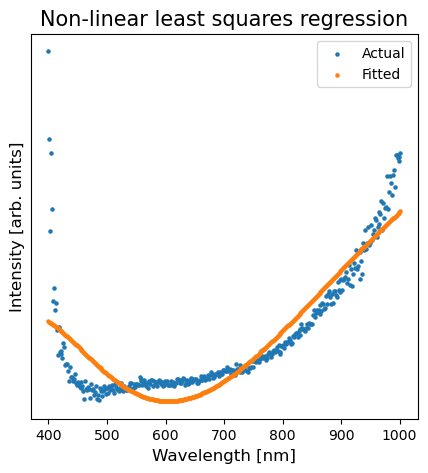

In [12]:
wl = wavelengths_arr
data = corrected_data[:,555,:][0]

# params = [a0, a1, a2 T]
params0 = np.array([1, 1, 1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[3], e)

curve_fit(wl, data, intensity, params0)

### Removing lower wavelengths (focusing on infrared)
The idea is to neglect non-blackbody signals from the camera's imperfections or the rod not being the only light source in the room.

Optimal parameters: [ 1.39536906e-12 -3.52680035e-06  2.41229507e+00  3.02192460e+03]
Final Cost: 0.006898804869331068
Termination Status: 2


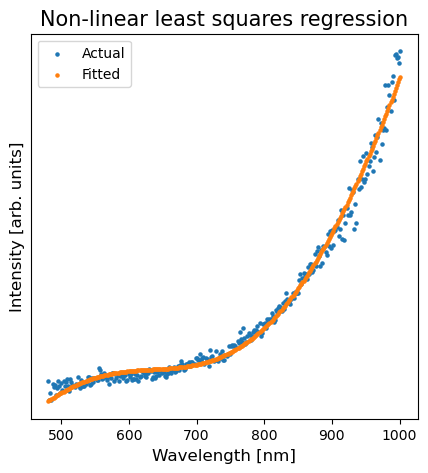

In [16]:
wl = wavelengths_arr[50:]
data = corrected_data[:,555,:][0][50:]

# params = [a0, a1, a2 T]
params0 = [1, 1, 1, 1000]
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[3], e)

result = curve_fit(wl, data, intensity, params0)

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_84490/3947752877.py:3: RuntimeWarning: overflow encountered in exp
  return e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))


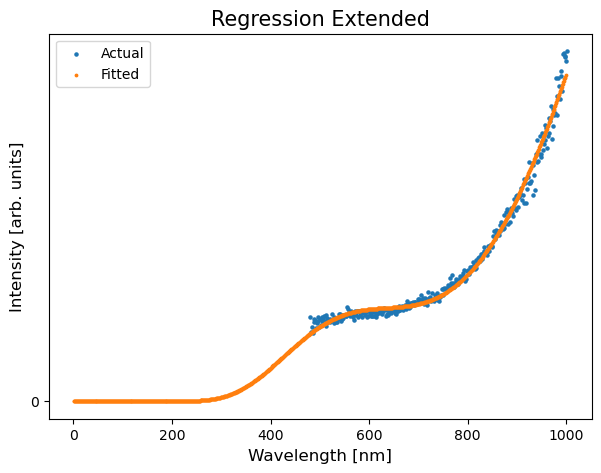

In [34]:
y = []
for l in np.arange(1, 1000, 1):
    y.append(intensity(result.x, l * 1e-9))

plt.figure(figsize=(7,5))
plt.scatter(wl, data, s=5)
plt.scatter(np.arange(1, 1000, 1), y, s=3)
plt.title("Regression Extended", fontsize=15)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Intensity [arb. units]", fontsize=12)
plt.yticks([0])
plt.legend(["Actual", "Fitted"], fontsize=10)

Optimal parameters: [ 2.79900369e-12 -6.80342701e-06  4.48201820e+00  2.72830207e+03]
Final Cost: 0.005552098718654477
Termination Status: 2


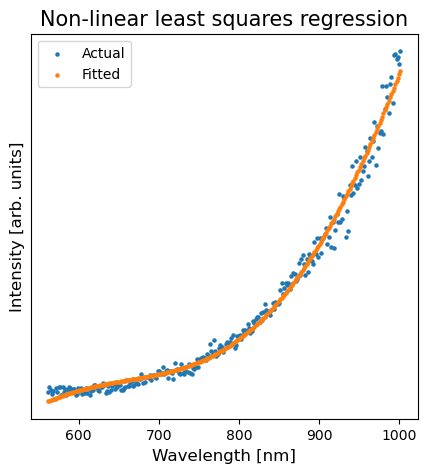

In [13]:
wl = wavelengths_arr[100:]
data = corrected_data[:,555,:][0][100:]

# params = [a0, a1, a2 T]
params0 = [0.5, 0.5, 0.5, 300]
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[3], e)

curve_fit(wl, data, intensity, params0)

Optimal parameters: [ 5.26913586e-09 -1.04264143e-02  5.33603227e+03  1.29087978e+03]
Final Cost: 0.0034046056266961357
Termination Status: 2


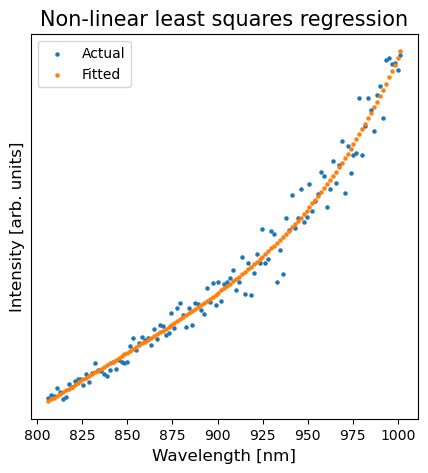

In [15]:
wl = wavelengths_arr[250:]
data = corrected_data[:,555,:][0][250:]

# params = [a0, a1, a2, T]
params0 = np.array([1, 1, 1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[3], e)

curve_fit(wl, data, intensity, params0)

### Decreasing Emissivity Order
If overfitting is the issue

Optimal parameters: [-2.98713367e-15  2.03587133e-07  3.02114629e+03]
Final Cost: 0.5682075313631938
Termination Status: 2


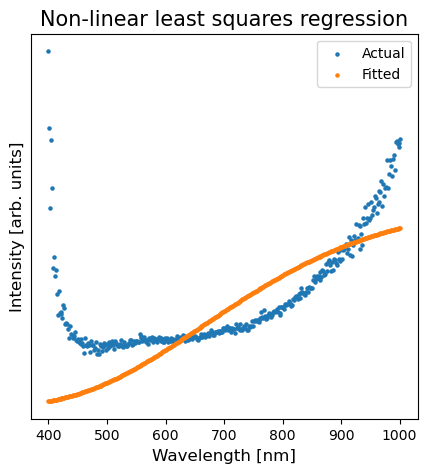

In [16]:
wl = wavelengths_arr
data = corrected_data[:,555,:][0]

# params = [a0, a1 T]
params0 = np.array([1, 1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l)
    return blackbody(l, params[2], e)

curve_fit(wl, data, intensity, params0)

Optimal parameters: [-4.82855203e-15  3.86530374e-07  2.70837296e+03]
Final Cost: 0.16162133439028947
Termination Status: 2


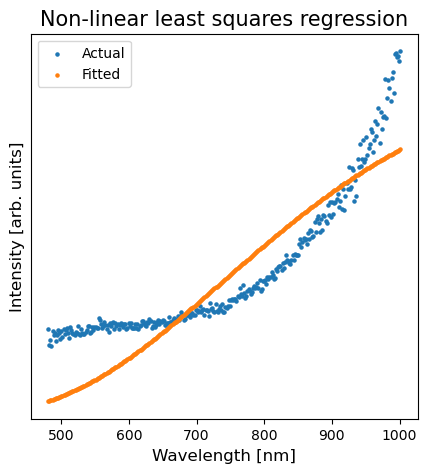

In [17]:
wl = wavelengths_arr[50:]
data = corrected_data[:,555,:][0][50:]

# params = [a0, a1 T]
params0 = np.array([1, 1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l)
    return blackbody(l, params[2], e)

curve_fit(wl, data, intensity, params0)

### Increasing Emissivity Order

Optimal parameters: [-1.11297417e-14  1.31373925e-06  2.24568659e+03]
Final Cost: 0.042428756452966065
Termination Status: 2


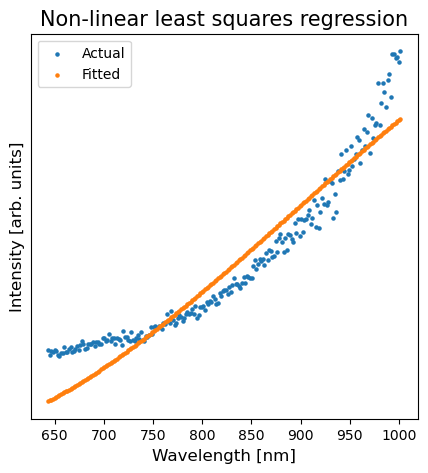

In [18]:
wl = wavelengths_arr[150:]
data = corrected_data[:,555,:][0][150:]

# params = [a0, a1 T]
params0 = np.array([1, 1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l)
    return blackbody(l, params[2], e)

curve_fit(wl, data, intensity, params0)

Optimal parameters: [-2.91739821e-14  5.70201499e-06  1.85011347e+03]
Final Cost: 0.0079816605018599
Termination Status: 2


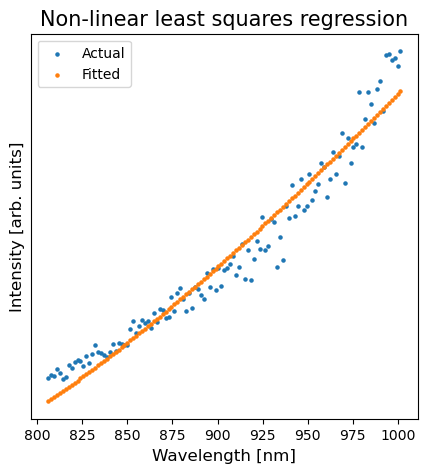

In [19]:
wl = wavelengths_arr[250:]
data = corrected_data[:,555,:][0][250:]

# params = [a0, a1 T]
params0 = np.array([1, 1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l)
    return blackbody(l, params[2], e)

curve_fit(wl, data, intensity, params0)

Optimal parameters: [-1.24102681e-15  2.27674544e-08 -6.40697180e-02  5.22343007e+04
  2.80465823e+00  8.35044763e+03]
Final Cost: 0.13663360759234006
Termination Status: 0


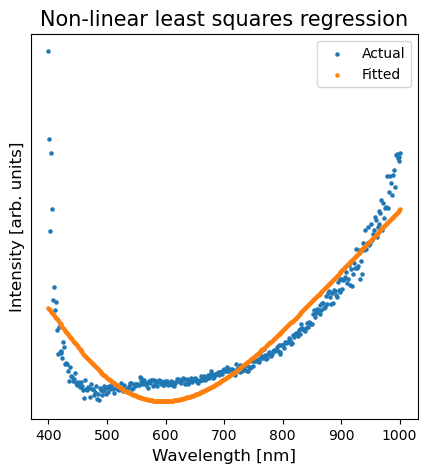

In [27]:
wl = wavelengths_arr
data = corrected_data[:,555,:][0]

# params = [a0, a1, a2, a3, a4, T]
params0 = [1, 1, 1, 1, 1, 1000]
def intensity(params, l):
    e = 0
    for i in range(5):
        e += params[i] * l**i
    return blackbody(l, params[5], e)

curve_fit(wl, data, intensity, params0)

Optimal parameters: [-5.31898390e-14  7.60638544e-07 -1.66772380e+00  1.08113689e+06
  1.00090986e+00  3.66393372e+03]
Final Cost: 0.006358467795646559
Termination Status: 0


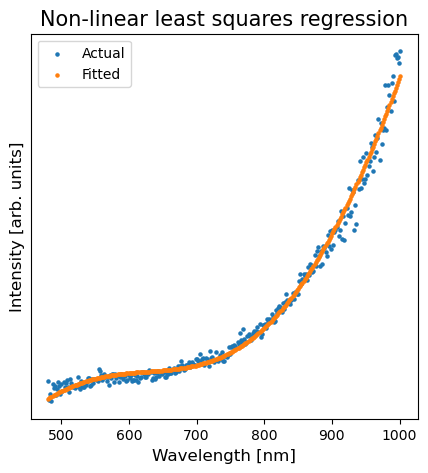

In [20]:
wl = wavelengths_arr[50:]
data = corrected_data[:,555,:][0][50:]

# params = [a0, a1, a2, a3, a4, T]
params0 = [1, 1, 1, 1, 1, 1000]
def intensity(params, l):
    e = 0
    for i in range(5):
        e += params[i] * l**i
    return blackbody(l, params[5], e)

curve_fit(wl, data, intensity, params0)

Optimal parameters: [ 5.26854485e-09 -1.04252481e-02  5.33544176e+03 -5.16220403e+01
  1.00000000e+00  1.29088972e+03]
Final Cost: 0.0034046056262285367
Termination Status: 3


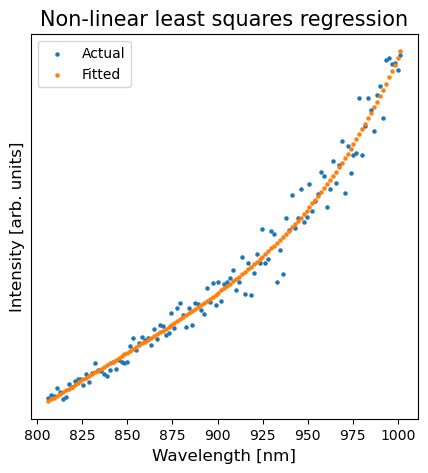

In [21]:
wl = wavelengths_arr[250:]
data = corrected_data[:,555,:][0][250:]

# params = [a0, a1, a2, a3, a4, T]
params0 = [1, 1, 1, 1, 1, 1000]
def intensity(params, l):
    e = 0
    for i in range(5):
        e += params[i] * l**i
    return blackbody(l, params[5], e)

curve_fit(wl, data, intensity, params0)

### Adding an Offset -- Success

Optimal parameters: [-5.19581074e-14  1.18383240e-04  1.29776195e+03  7.98633325e-02]
Final Cost: 0.004772050621899818
Termination Status: 2


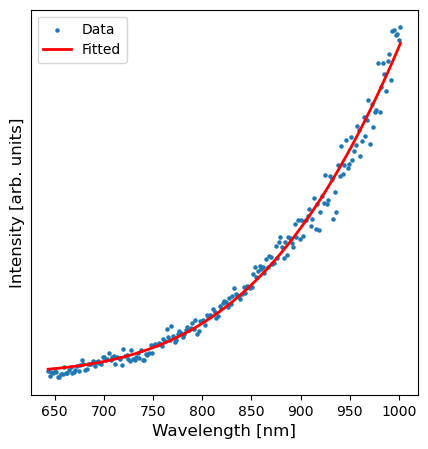

In [33]:
wl = wavelengths_arr[150:]
data = corrected_data[:,555,:][0][150:]

# l: wavelength, T: temperature, e: emissivity
def blackbody_offset(l, T, e, offset):
    return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

def residuals(params):
    result = []
    for i in range(len(wl)):
        Si = intensity(params, wl[i] * 1e-9)
        St = data[i]
        result.append(Si - St)
    return np.array(result)

# params = [a0, a1, T, k]
params0 = np.array([1, 1, 1000, 0.1])
def intensity(params, l):
    e = params[0] + (params[1] * l)
    return blackbody_offset(l, params[2], e, params[3])

result = least_squares(residuals, params0)
print(f"Optimal parameters: {result.x}\nFinal Cost: {result.cost}\nTermination Status: {result.status}")

yfit = []
for l in wl:
    yfit.append(intensity(result.x, l * 1e-9))
    
plt.figure(figsize=(5,5))
plt.scatter(wl, data, s=5)
plt.plot(wl, yfit, linewidth=2, color="red")
# plt.title("Non-linear least squares regression", fontsize=15)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Intensity [arb. units]", fontsize=12)
plt.yticks([])
plt.legend(["Data", "Fitted"], fontsize=10)
plt.show()

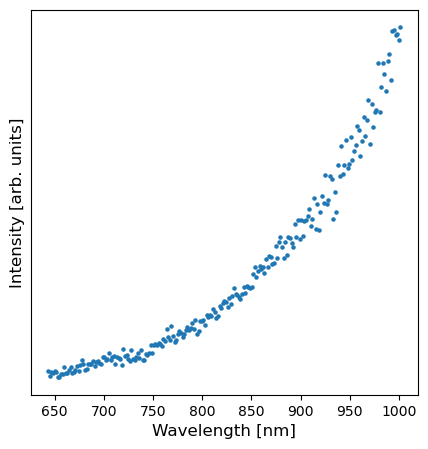

In [32]:
plt.figure(figsize=(5,5))
plt.scatter(wl, data, s=5)
# plt.title("Non-linear least squares regression", fontsize=15)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Intensity [arb. units]", fontsize=12)
plt.yticks([])
plt.show()

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_10093/1784070983.py:6: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


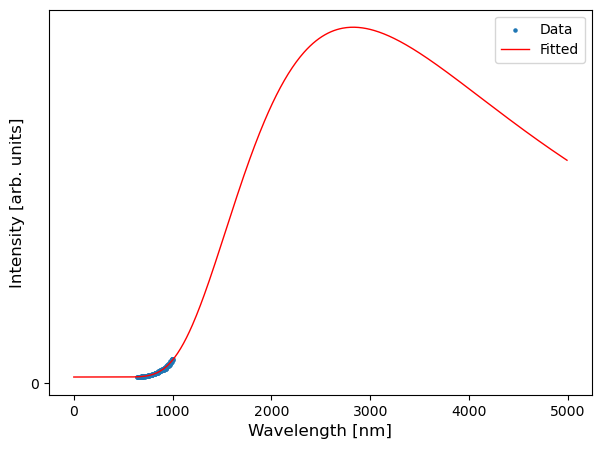

In [34]:
y = []
for l in np.arange(1, 5000, 10):
    y.append(intensity(result.x, l * 1e-9))

plt.figure(figsize=(7,5))
plt.scatter(wl, data, s=5)
plt.plot(np.arange(1, 5000, 10), y, color="red", linewidth=1)
# plt.title("Regression Extended", fontsize=15)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Intensity [arb. units]", fontsize=12)
plt.yticks([0])
plt.legend(["Data", "Fitted"], fontsize=10)

Optimal parameters: [-3.18572175e-14  7.51659660e-05  1.35431307e+03  7.53661739e-02]
Final Cost: 0.006000584855054658
Termination Status: 2


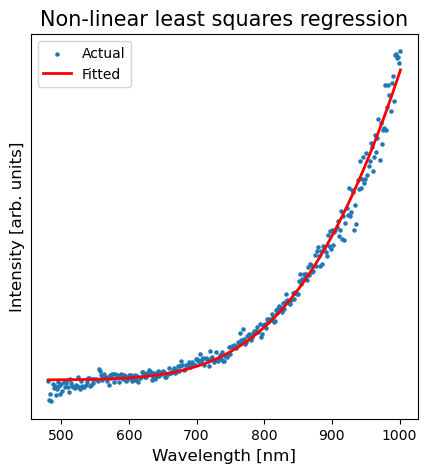

In [26]:
wl = wavelengths_arr[50:]
data = corrected_data[:,555,:][0][50:]

# l: wavelength, T: temperature, e: emissivity
def blackbody_offset(l, T, e, offset):
    return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

def residuals(params):
    result = []
    for i in range(len(wl)):
        Si = intensity(params, wl[i] * 1e-9)
        St = data[i]
        result.append(Si - St)
    return np.array(result)

# params = [a0, a1, T, k]
params0 = np.array([1, 1, 1000, 0.1])
def intensity(params, l):
    e = params[0] + (params[1] * l)
    return blackbody_offset(l, params[2], e, params[3])

result = least_squares(residuals, params0)
print(f"Optimal parameters: {result.x}\nFinal Cost: {result.cost}\nTermination Status: {result.status}")

yfit = []
for l in wl:
    yfit.append(intensity(result.x, l * 1e-9))
    
plt.figure(figsize=(5,5))
plt.scatter(wl, data, s=5)
plt.plot(wl, yfit, linewidth=2, color="red")
plt.title("Non-linear least squares regression", fontsize=15)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Intensity [arb. units]", fontsize=12)
plt.yticks([])
plt.legend(["Actual", "Fitted"], fontsize=10)
plt.show()

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_10093/3518534030.py:6: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


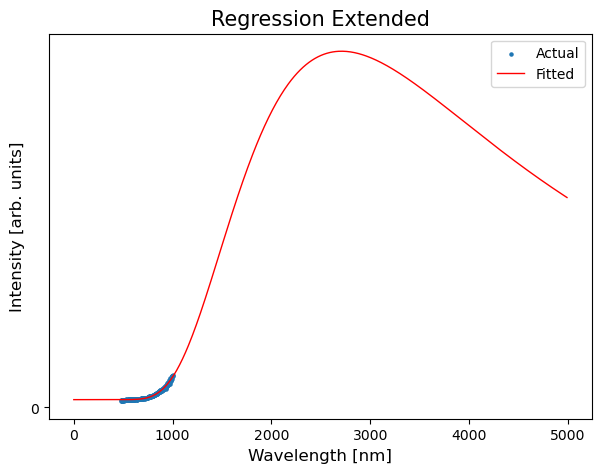

In [23]:
y = []
for l in np.arange(1, 5000, 10):
    y.append(intensity(result.x, l * 1e-9))

plt.figure(figsize=(7,5))
plt.scatter(wl, data, s=5)
plt.plot(np.arange(1, 5000, 10), y, color="red", linewidth=1)
plt.title("Regression Extended", fontsize=15)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Intensity [arb. units]", fontsize=12)
plt.yticks([0])
plt.legend(["Actual", "Fitted"], fontsize=10)

Optimal parameters: [1.88913681e-10 1.24581919e+03 7.56004648e-02]
Final Cost: 0.006146613763665036
Termination Status: 2


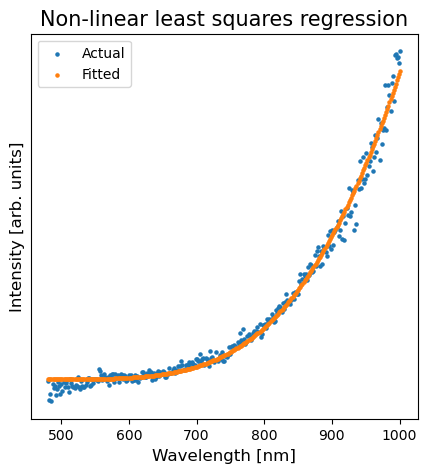

In [15]:
wl = wavelengths_arr[50:]
data = corrected_data[:,555,:][0][50:]

# l: wavelength, T: temperature, e: emissivity
def blackbody_offset(l, T, e, offset):
    return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

def residuals(params):
    result = []
    for i in range(len(wl)):
        Si = intensity(params, wl[i] * 1e-9)
        St = data[i]
        result.append(Si - St)
    return np.array(result)

# params = [a0, a1, T, k]
params0 = np.array([1, 1000, 0.1])
def intensity(params, l):
    e = params[0]
    return blackbody_offset(l, params[1], e, params[2])

result = least_squares(residuals, params0)
print(f"Optimal parameters: {result.x}\nFinal Cost: {result.cost}\nTermination Status: {result.status}")

yfit = []
for l in wl:
    yfit.append(intensity(result.x, l * 1e-9))
    
plt.figure(figsize=(5,5))
plt.scatter(wl, data, s=5)
plt.scatter(wl, yfit, s=5)
plt.title("Non-linear least squares regression", fontsize=15)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Intensity [arb. units]", fontsize=12)
plt.yticks([])
plt.legend(["Actual", "Fitted"], fontsize=10)
plt.show()

Optimal parameters: [5.14514283e-12 1.59779810e+03 7.52635738e-02]
Final Cost: 0.0032252761902295713
Termination Status: 2


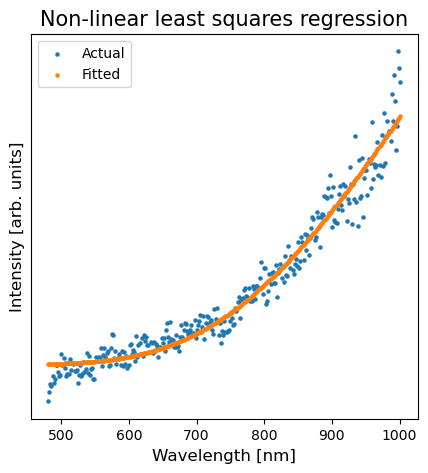

In [16]:
wl = wavelengths_arr[50:]
data = corrected_data[:,555,:][-1][50:]

# l: wavelength, T: temperature, e: emissivity
def blackbody_offset(l, T, e, offset):
    return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

def residuals(params):
    result = []
    for i in range(len(wl)):
        Si = intensity(params, wl[i] * 1e-9)
        St = data[i]
        result.append(Si - St)
    return np.array(result)

# params = [a0, T, k]
params0 = np.array([1, 1000, 0.1])
def intensity(params, l):
    e = params[0]
    return blackbody_offset(l, params[1], e, params[2])

result = least_squares(residuals, params0)
print(f"Optimal parameters: {result.x}\nFinal Cost: {result.cost}\nTermination Status: {result.status}")

yfit = []
for l in wl:
    yfit.append(intensity(result.x, l * 1e-9))
    
plt.figure(figsize=(5,5))
plt.scatter(wl, data, s=5)
plt.scatter(wl, yfit, s=5)
plt.title("Non-linear least squares regression", fontsize=15)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Intensity [arb. units]", fontsize=12)
plt.yticks([])
plt.legend(["Actual", "Fitted"], fontsize=10)
plt.show()

## KFold (from https://github.com/pytaunay/multiwavelength-pyrometry)
This paper supplies code that fits the spectrum similar to the previous method, but does not require a model for emissivity to be pre-selected. Instead, this method selects the polynomial order of the emissivity as a function of wavelength as part of the fitting.

### Exploring

In [50]:
def kfold(wl_vec, I):
    # Black and gray body
    bb_eps = lambda wl,T: 1.0 * np.ones(len(wl))
    # gr_eps = lambda wl,T: 0.5 * np.ones(len(wl))
    
    # Parameters
    Nwl = len(wl_vec)
    
    pix_vec = np.linspace(0,len(wl_vec)-1,len(wl_vec))
    pix_vec = np.array(pix_vec,dtype=np.int64)
        
    # I_calc = gs.wien_approximation(wl_vec,T,eps2)
    I_calc = I
    noisy_data = np.copy(I_calc)
    
    # Take the log of the data
    
    log_noisy = np.log(noisy_data)
    
    wl_vec_sub = np.copy(wl_vec)
    log_med = np.copy(log_noisy)
    pix_vec_sub = np.copy(pix_vec)
    
    ### Fit a spline to access data easily
    data_spl = splrep(wl_vec_sub,log_med)
    
    pix_sub_vec = np.copy(pix_vec_sub)
    filtered_data = np.copy(log_med)
    
    
    #I_calc,noisy_data,filtered_data,data_spl,pix_sub_vec = gs.generate_data(
    #        wl_vec,T,pix_vec,f_eps,el)
    wl_sub_vec = wl_vec[pix_sub_vec]
    
    ### Choose the order of the emissivity w/ k-fold
    poly_order = order_selection(data_spl,
                           pix_sub_vec,wl_vec,
                           bb_eps)
    
    ### Calculate the temperature using the whole dataset
    # Pixel operations
    chosen_pix = choose_pixels(pix_sub_vec,bin_method='average')
    cmb_pix = generate_combinations(chosen_pix,pix_sub_vec)
    
    # Compute the temperature
    Tave, Tstd, Tmetric, sol = optimum_temperature(data_spl,cmb_pix,
                                                pix_sub_vec,wl_vec,
                                                poly_order)
    
    print(f"Average Temp. = {Tave}, St. Dev. = {Tstd}")
    
    ### Reconstruct data
    bb_reconstructed = gs.wien_approximation(wl_sub_vec,Tave,bb_eps)
    #eps_vec_reconstructed = 10**filtered_data/bb_reconstructed
    eps_vec_reconstructed = np.exp(filtered_data)/bb_reconstructed
    # Since we get epsilon from the filtered data, "reconstructed_data" will be
    # exactly like "filtered_data"
    reconstructed_data = bb_reconstructed * eps_vec_reconstructed # exactly filtered   
    
    # Alternative using the polynomial from optimization
    reconstructed_alt = gs.wien_approximation(wl_sub_vec,Tave,bb_eps)
    wl_min = np.min(wl_sub_vec)
    wl_max = np.max(wl_sub_vec)
    
    if poly_order > 0:
        cheb = Polynomial(sol.x,[wl_min,wl_max])
        eps_vec = polynomial.polyval(wl_sub_vec,cheb.coef)
        
    else:
        eps_ave = np.average(eps_vec_reconstructed)
        eps_vec = eps_ave * np.ones(len(wl_sub_vec))
        
    reconstructed_alt *= eps_vec
    
    
    #### Plots
    fig, ax = plt.subplots(2,1)
    ax[0].semilogy(wl_vec,noisy_data, linewidth=5)
    ax[0].semilogy(wl_sub_vec,reconstructed_data, linewidth=3)
    ax[0].semilogy(wl_vec, I, linewidth=1)
    
    # ax[1].plot(wl_vec,eps2(wl_vec,T))
    ax[1].plot(wl_sub_vec,eps_vec_reconstructed)
    
    return Tave, Tstd

Average Temp. = 3232.459438254662, St. Dev. = 1015.2999460229403


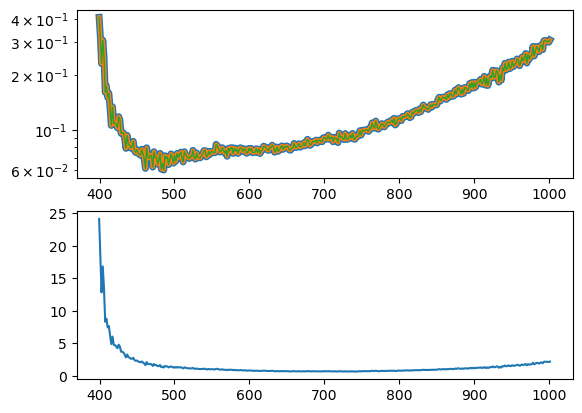

In [23]:
_ = kfold(wavelengths_arr, corrected_data[:,555,:][0])

Average Temp. = 3735.855934391062, St. Dev. = 456.8040250388294


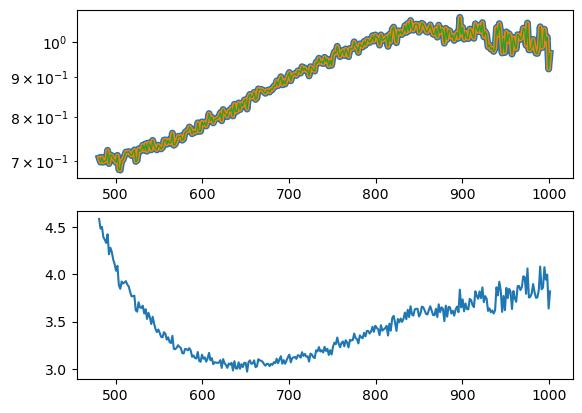

In [24]:
_ = kfold(wavelengths_arr[50:], corrected_data[:,55,:][0][50:])

Average Temp. = 3234.332266870451, St. Dev. = 423.52574463997206


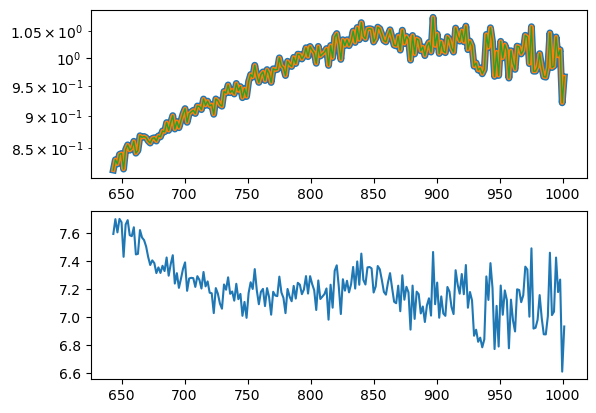

In [28]:
_ = kfold(wavelengths_arr[150:], corrected_data[:,55,:][0][150:])

Average Temp. = 1638.210755738988, St. Dev. = 238.20544467583207


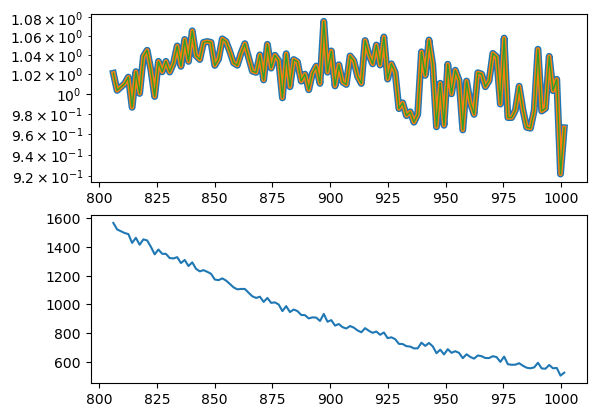

In [29]:
_ = kfold(wavelengths_arr[250:], corrected_data[:,55,:][0][250:])

Average Temp. = 4589.468320412662, St. Dev. = 1540.8827111061385


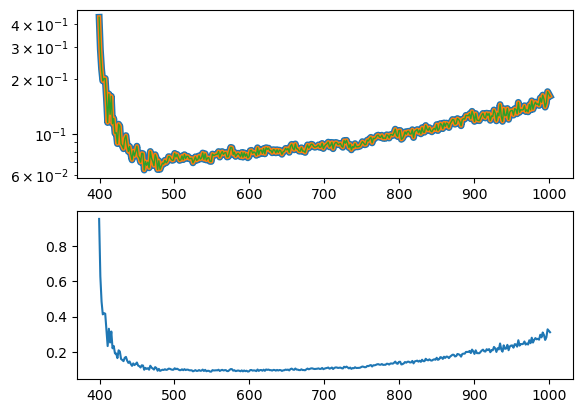

In [25]:
_ = kfold(wavelengths_arr, corrected_data[:,555,:][-1])

Average Temp. = 3773.62087470383, St. Dev. = 782.6333157521786


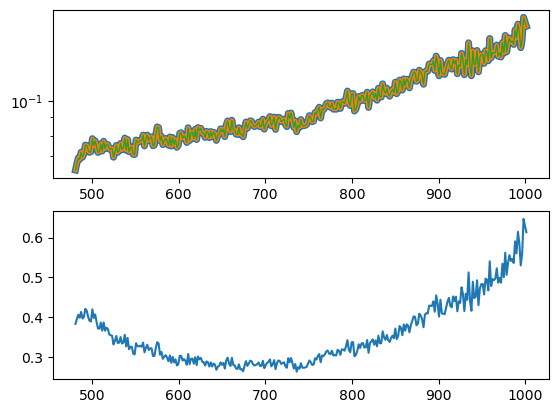

In [26]:
_ = kfold(wavelengths_arr[50:], corrected_data[:,555,:][-1][50:])

Average Temp. = 2677.126445733375, St. Dev. = 704.5698658066933


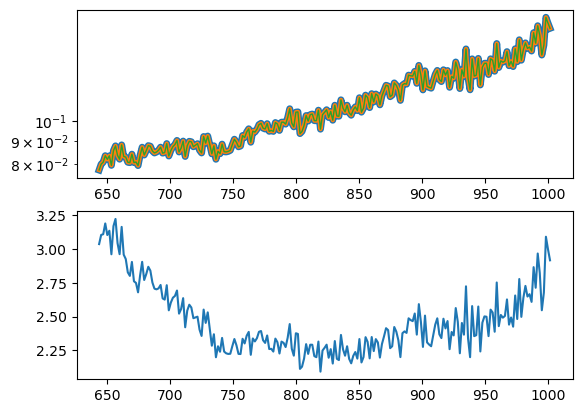

In [30]:
_ = kfold(wavelengths_arr[150:], corrected_data[:,555,:][-1][150:])

Average Temp. = 1018.0474196715613, St. Dev. = 253.63040025894153


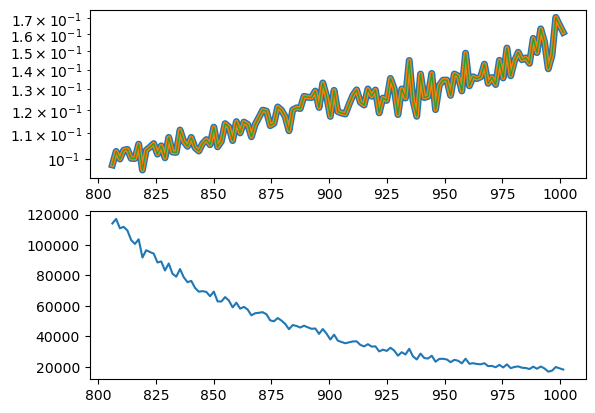

In [31]:
_ = kfold(wavelengths_arr[250:], corrected_data[:,555,:][-1][250:])

Average Temp. = 1015.9750858217578, St. Dev. = 217.71163252196507


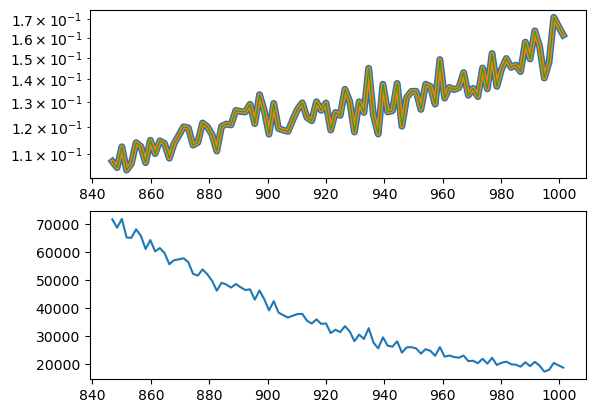

In [37]:
_ = kfold(wavelengths_arr[275:], corrected_data[:,555,:][-1][275:])

Average Temp. = 920.8140852071323, St. Dev. = 259.1799992159013


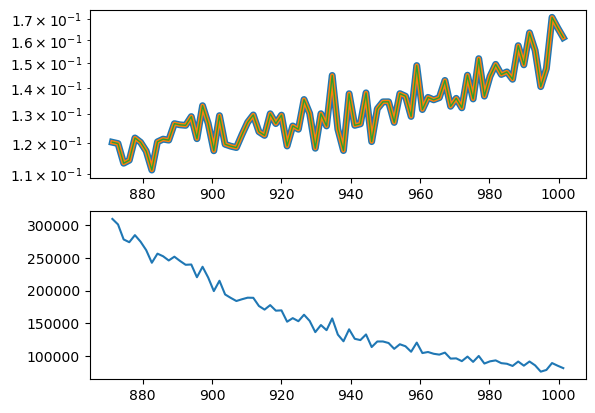

In [38]:
_ = kfold(wavelengths_arr[290:], corrected_data[:,555,:][-1][290:])

Average Temp. = 923.470797105096, St. Dev. = 362.22459259304617


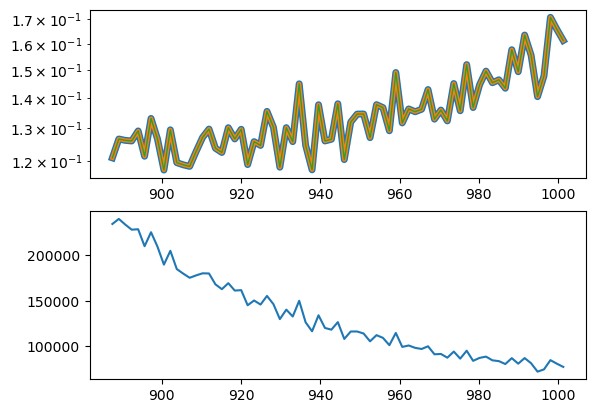

In [39]:
_ = kfold(wavelengths_arr[300:], corrected_data[:,555,:][-1][300:])

### Temp based on points used

In [81]:
wavelengths_arr[300]

887.493

Index = 0
Average Temp. = 3530.952226120826, St. Dev. = 1107.4975148336953
Index = 50
Average Temp. = 3142.2261155481006, St. Dev. = 487.55232754572444
Index = 100
Average Temp. = 2870.444307165519, St. Dev. = 490.659612490306
Index = 150
Average Temp. = 2528.877262958524, St. Dev. = 452.167432068037
Index = 200
Average Temp. = 1496.6602320834754, St. Dev. = 284.72211596106246
Index = 250
Average Temp. = 1218.8151088426107, St. Dev. = 303.94938261733597
Index = 300
Average Temp. = 834.4214726023814, St. Dev. = 227.83172052753457
Index = 350


/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divi

Average Temp. = 1101.46962785415, St. Dev. = 519.0780829994253
Time = 299.0388720035553 seconds


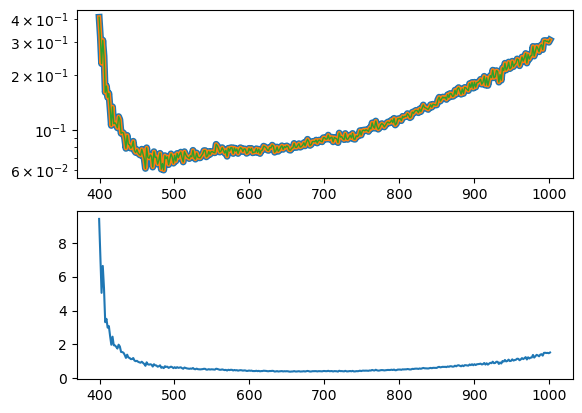

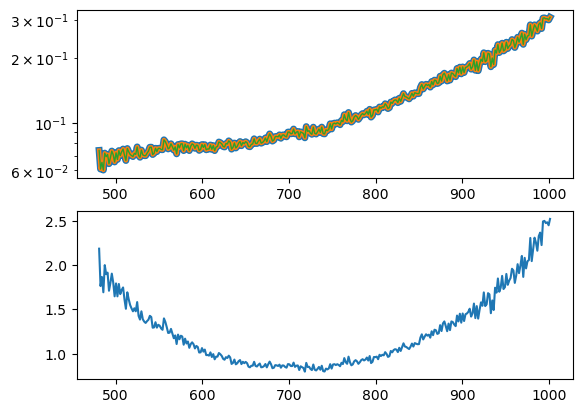

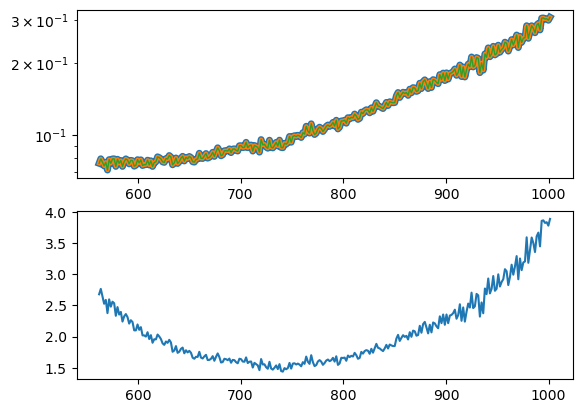

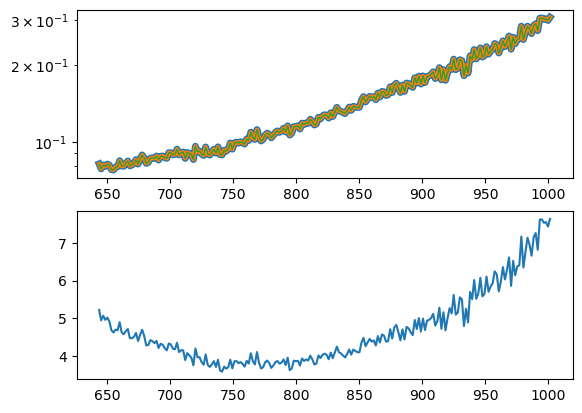

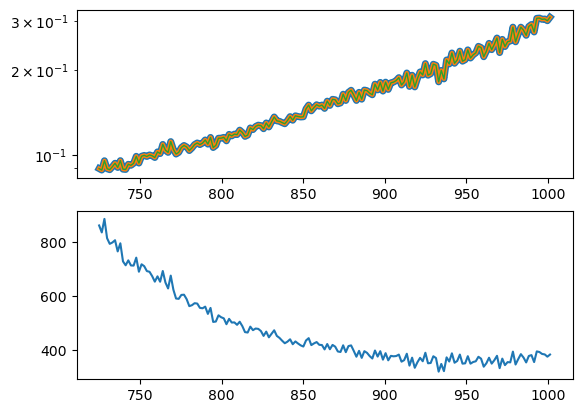

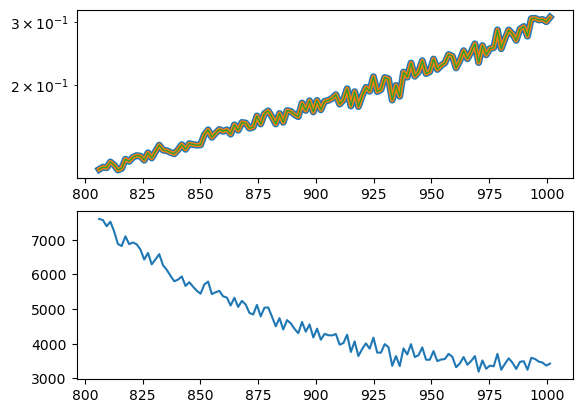

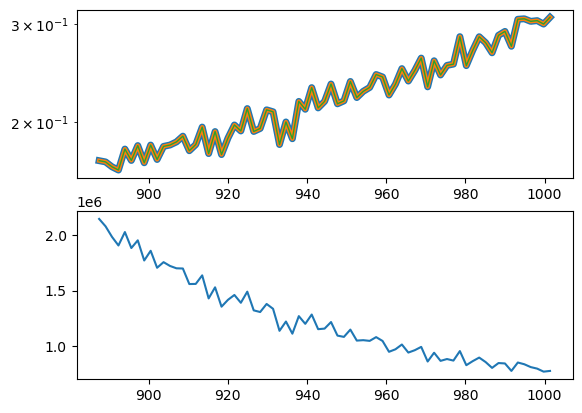

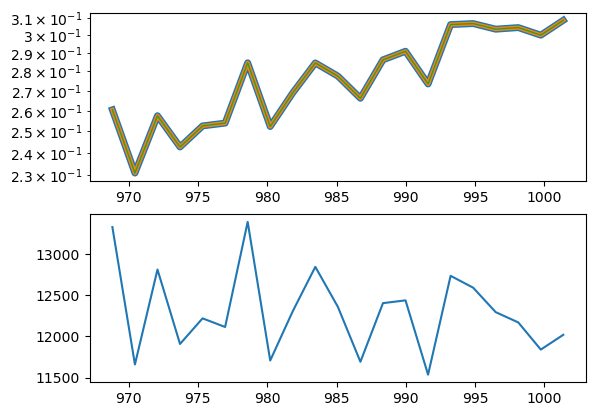

In [69]:
indices = np.arange(0, len(wavelengths_arr), 50)
ave, std = [], []
ti = time.time()
for index in indices:
    print(f"Index = {index}")
    Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][0][index:])
    ave.append(Tave), std.append(Tstd)
tf = time.time()
print(f"Time = {tf - ti} seconds")

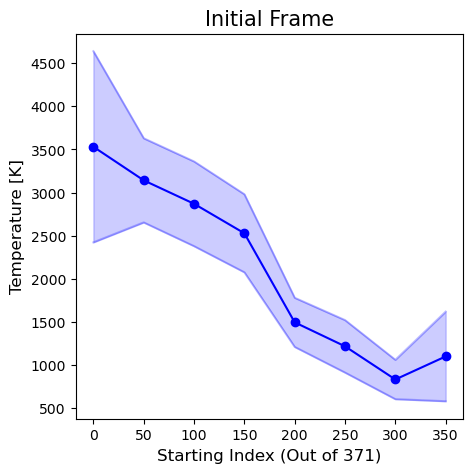

In [70]:
Ttop, Tbot = [], []
for i in range(len(ave)):
    Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

plt.figure(figsize=(5,5))
plt.title("Initial Frame", fontsize=15)
plt.xlabel("Starting Index (Out of 371)", fontsize=12)
plt.ylabel("Temperature [K]", fontsize=12)

plt.plot(indices, ave, color="blue")
plt.scatter(indices, ave, color="blue")
plt.plot(indices, Ttop, color="blue", alpha=0.25)
# plt.scatter(indices, Ttop, color="blue")
plt.plot(indices, Tbot, color="blue", alpha=0.25)
# plt.scatter(indices, Tbot, color="blue")
plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

plt.show()

Index = 0
Average Temp. = 4471.085989044462, St. Dev. = 1437.8124621231907
Index = 50
Average Temp. = 3847.8996552953813, St. Dev. = 812.288306707042
Index = 100
Average Temp. = 3039.3702490678143, St. Dev. = 624.0006790019947
Index = 150
Average Temp. = 2677.126445733375, St. Dev. = 704.5698658066933
Index = 200
Average Temp. = 1802.7519627765416, St. Dev. = 489.86867240529097
Index = 250
Average Temp. = 1018.0474196715613, St. Dev. = 253.63040025894153
Index = 300
Average Temp. = 923.470797105096, St. Dev. = 362.22459259304617
Index = 350


/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divi

Average Temp. = 2265.2177011454064, St. Dev. = 3755.8739400886693
Time = 263.0563850402832 seconds


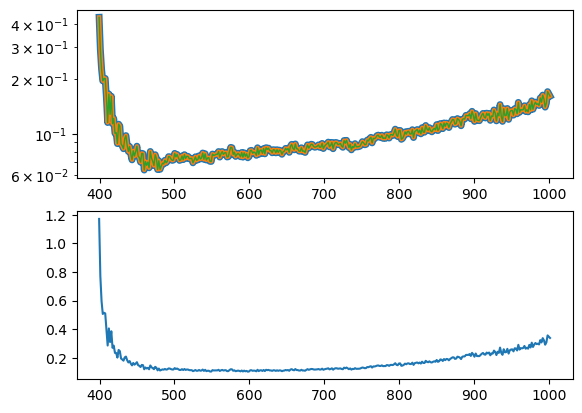

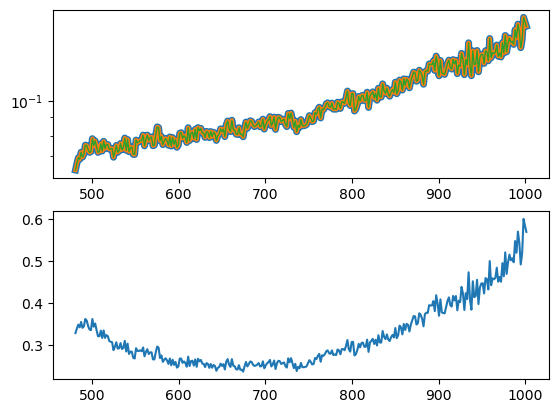

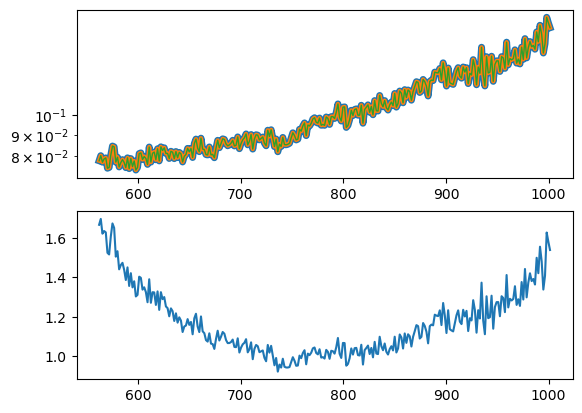

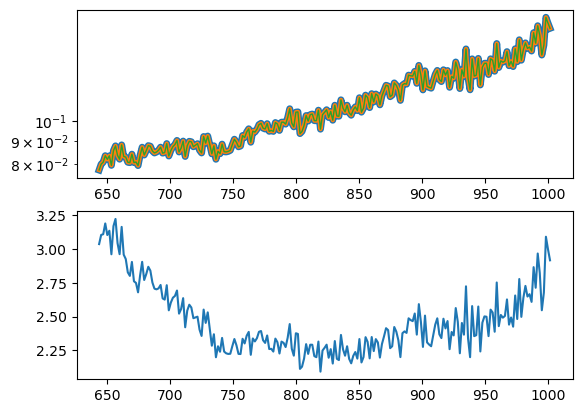

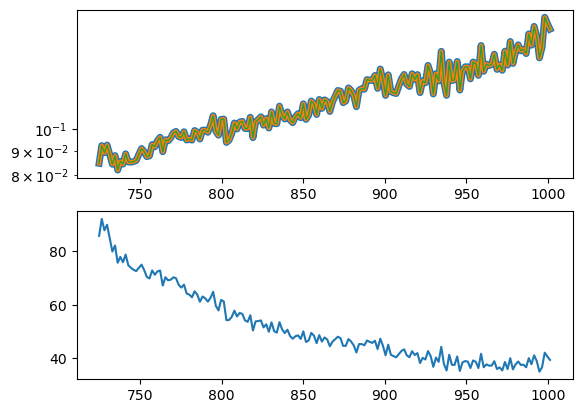

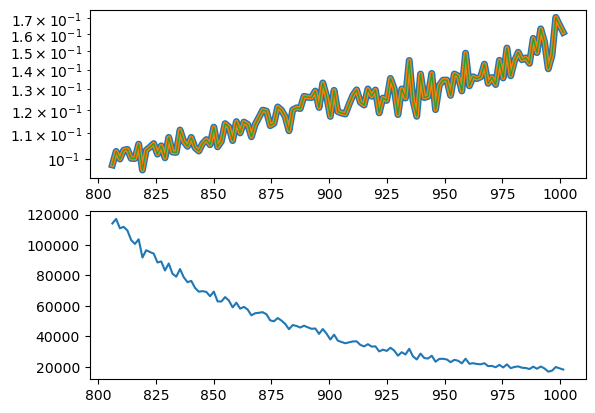

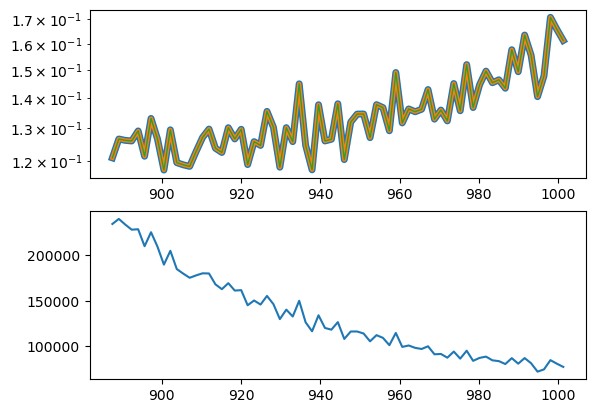

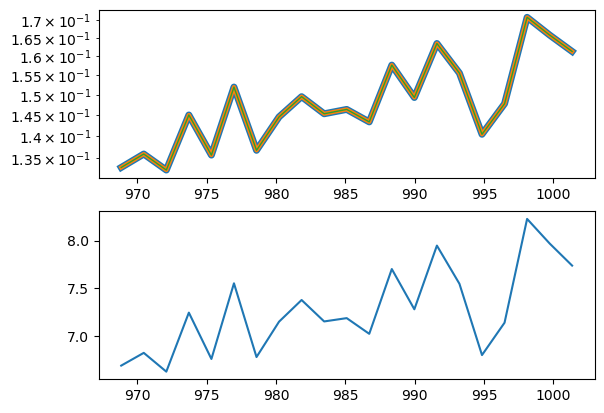

In [52]:
indices = np.arange(0, len(wavelengths_arr), 50)
ave, std = [], []
ti = time.time()
for index in indices:
    print(f"Index = {index}")
    Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][-1][index:])
    ave.append(Tave), std.append(Tstd)
tf = time.time()
print(f"Time = {tf - ti} seconds")

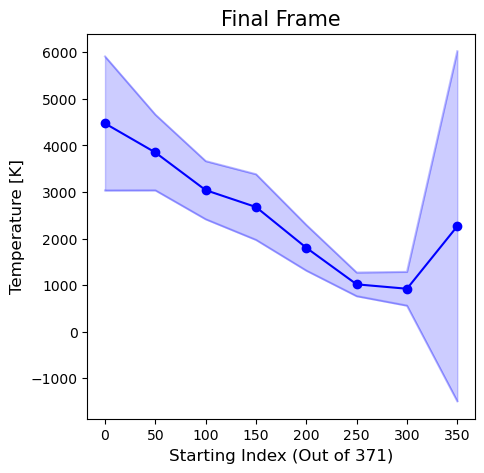

In [68]:
Ttop, Tbot = [], []
for i in range(len(ave)):
    Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

plt.figure(figsize=(5,5))
plt.title("Final Frame", fontsize=15)
plt.xlabel("Starting Index (Out of 371)", fontsize=12)
plt.ylabel("Temperature [K]", fontsize=12)

plt.plot(indices, ave, color="blue")
plt.scatter(indices, ave, color="blue")
plt.plot(indices, Ttop, color="blue", alpha=0.25)
# plt.scatter(indices, Ttop, color="blue")
plt.plot(indices, Tbot, color="blue", alpha=0.25)
# plt.scatter(indices, Tbot, color="blue")
plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

plt.show()

Index = 0
Average Temp. = 3530.952226120826, St. Dev. = 1107.4975148336953
Index = 50
Average Temp. = 3142.2261155481006, St. Dev. = 487.55232754572444
Index = 100
Average Temp. = 2870.444307165519, St. Dev. = 490.659612490306
Index = 150
Average Temp. = 1785.5413470664453, St. Dev. = 326.14171372674986
Index = 200
Average Temp. = 1791.656051994392, St. Dev. = 394.517914587079
Index = 250
Average Temp. = 1311.2748076520325, St. Dev. = 258.2731341791913
Index = 300
Average Temp. = 807.4313330357037, St. Dev. = 205.8910765093523
Index = 350


/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divi

Average Temp. = 1101.46962785415, St. Dev. = 519.0780829994253
Time = 254.6486690044403 seconds


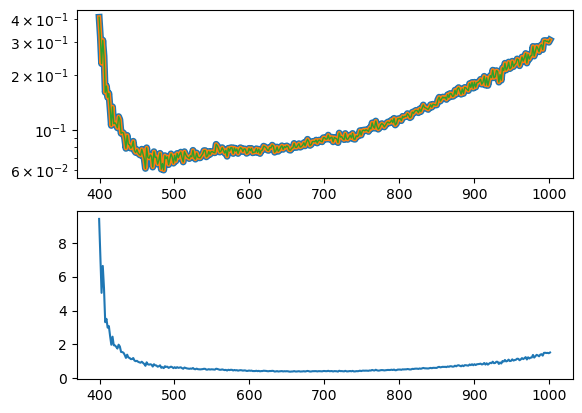

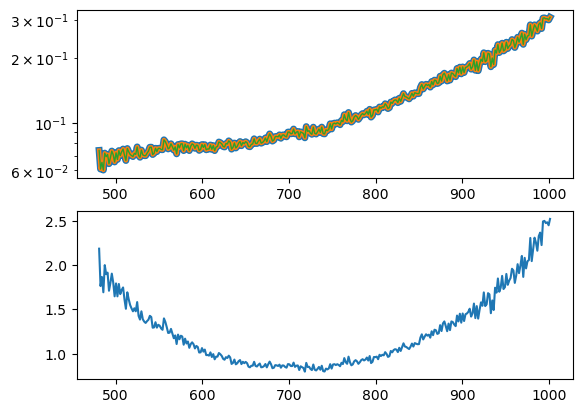

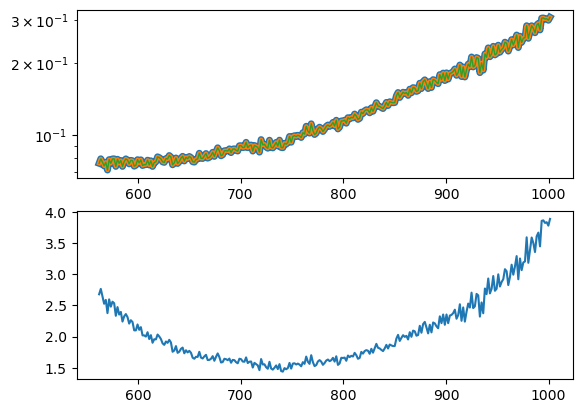

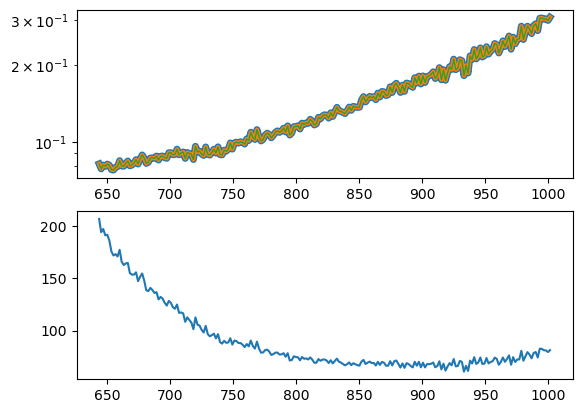

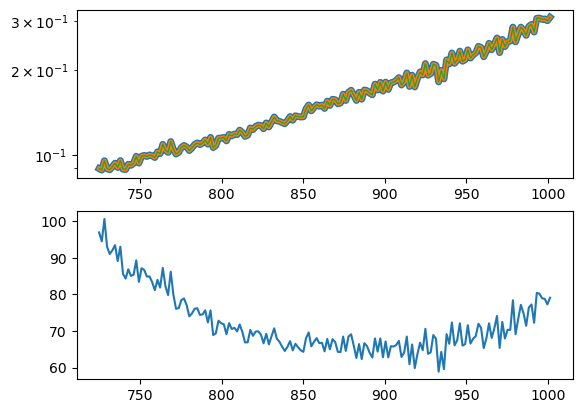

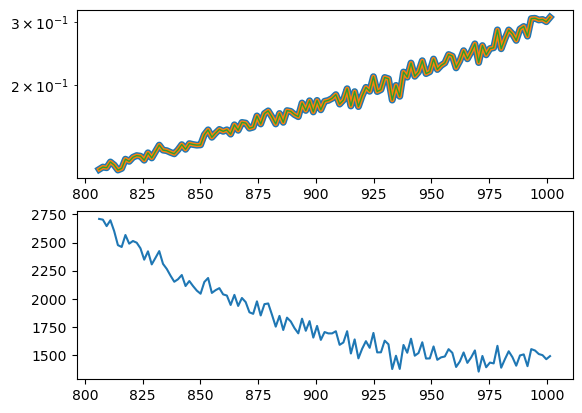

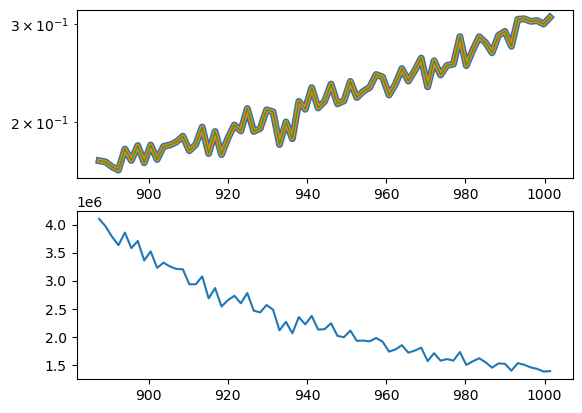

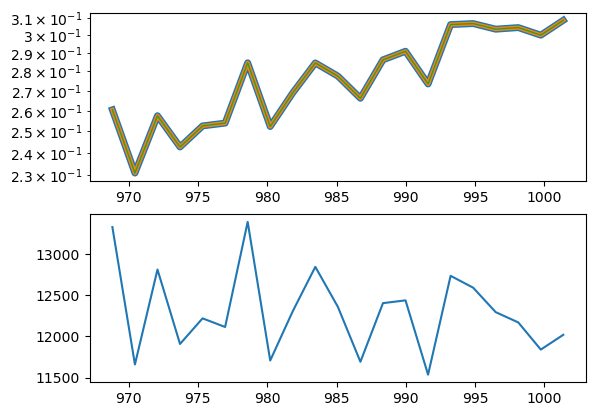

In [72]:
indices = np.arange(0, len(wavelengths_arr), 50)
ave, std = [], []
ti = time.time()
for index in indices:
    print(f"Index = {index}")
    Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][0][index:])
    ave.append(Tave), std.append(Tstd)
tf = time.time()
print(f"Time = {tf - ti} seconds")

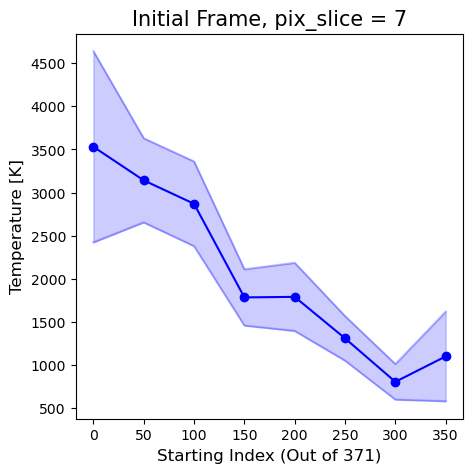

In [73]:
Ttop, Tbot = [], []
for i in range(len(ave)):
    Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

plt.figure(figsize=(5,5))
plt.title("Initial Frame, pix_slice = 7", fontsize=15)
plt.xlabel("Starting Index (Out of 371)", fontsize=12)
plt.ylabel("Temperature [K]", fontsize=12)

plt.plot(indices, ave, color="blue")
plt.scatter(indices, ave, color="blue")
plt.plot(indices, Ttop, color="blue", alpha=0.25)
# plt.scatter(indices, Ttop, color="blue")
plt.plot(indices, Tbot, color="blue", alpha=0.25)
# plt.scatter(indices, Tbot, color="blue")
plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

plt.show()

Index = 0
Average Temp. = 4589.468320412662, St. Dev. = 1540.8827111061385
Index = 50
Average Temp. = 3847.8996552953813, St. Dev. = 812.288306707042
Index = 100
Average Temp. = 3039.3702490678143, St. Dev. = 624.0006790019947
Index = 150
Average Temp. = 2677.126445733375, St. Dev. = 704.5698658066933
Index = 200
Average Temp. = 1802.7519627765416, St. Dev. = 489.86867240529097
Index = 250
Average Temp. = 1018.0474196715613, St. Dev. = 253.63040025894153
Index = 300
Average Temp. = 923.470797105096, St. Dev. = 362.22459259304617
Index = 350


/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divi

Average Temp. = 2265.2177011454064, St. Dev. = 3755.8739400886693
Time = 219.76880311965942 seconds


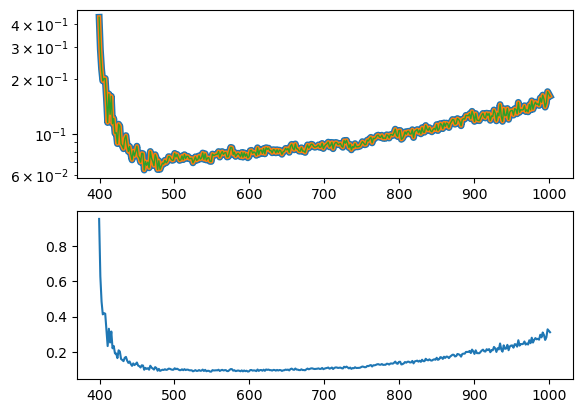

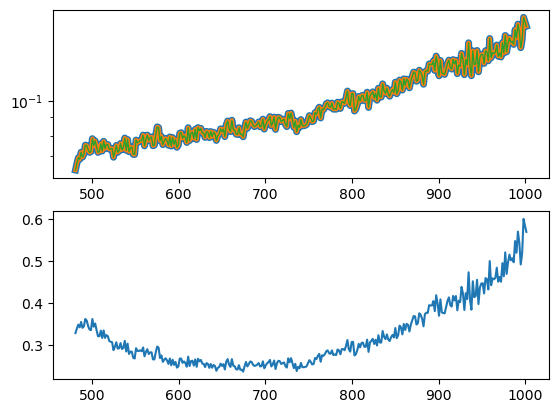

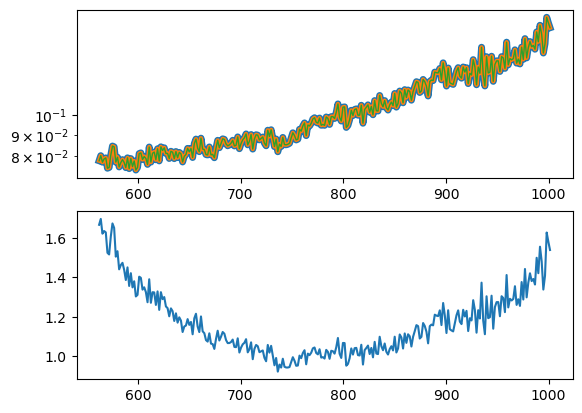

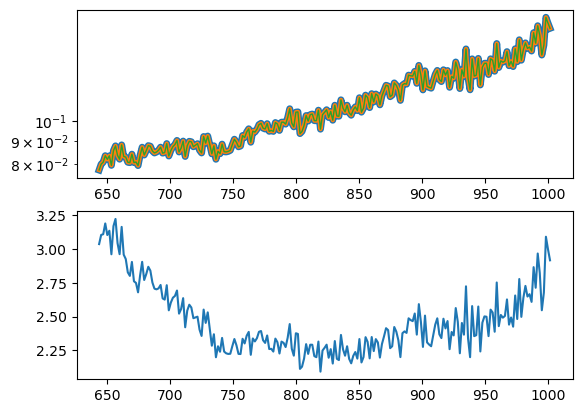

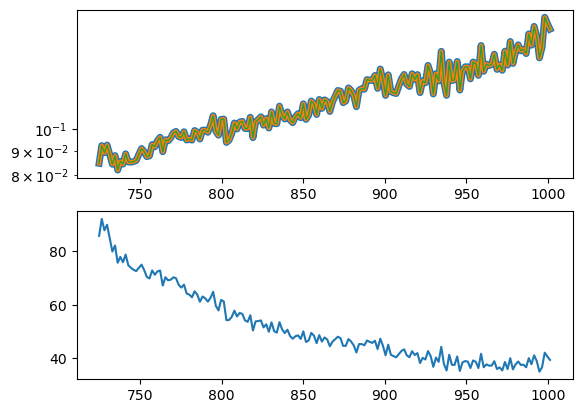

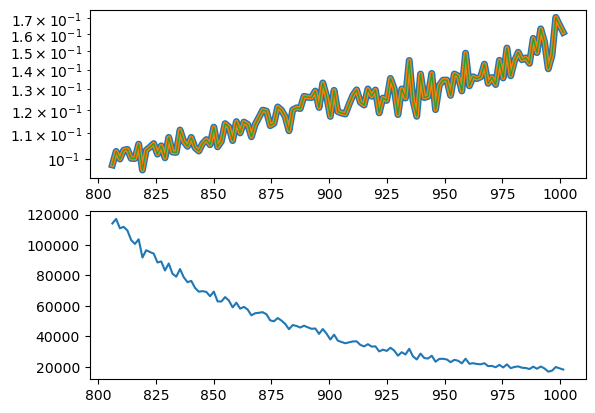

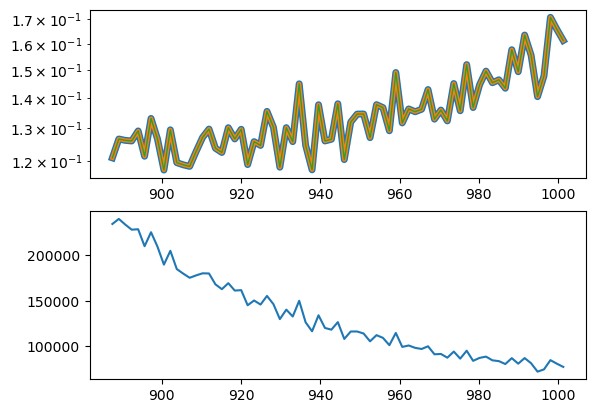

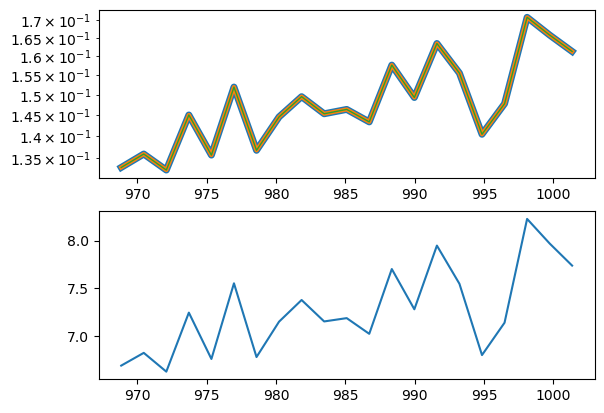

In [74]:
indices = np.arange(0, len(wavelengths_arr), 50)
ave, std = [], []
ti = time.time()
for index in indices:
    print(f"Index = {index}")
    Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][-1][index:])
    ave.append(Tave), std.append(Tstd)
tf = time.time()
print(f"Time = {tf - ti} seconds")

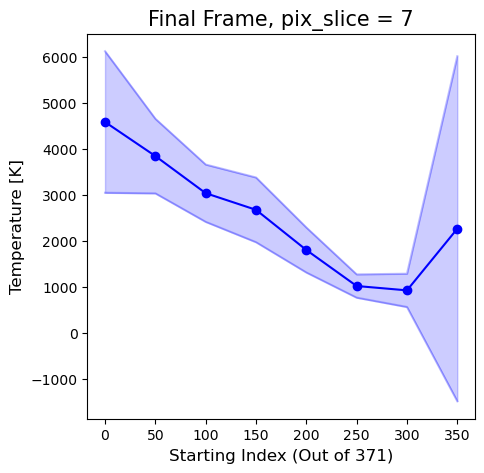

In [75]:
Ttop, Tbot = [], []
for i in range(len(ave)):
    Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

plt.figure(figsize=(5,5))
plt.title("Final Frame, pix_slice = 7", fontsize=15)
plt.xlabel("Starting Index (Out of 371)", fontsize=12)
plt.ylabel("Temperature [K]", fontsize=12)

plt.plot(indices, ave, color="blue")
plt.scatter(indices, ave, color="blue")
plt.plot(indices, Ttop, color="blue", alpha=0.25)
# plt.scatter(indices, Ttop, color="blue")
plt.plot(indices, Tbot, color="blue", alpha=0.25)
# plt.scatter(indices, Tbot, color="blue")
plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

plt.show()

Index = 0
Average Temp. = 3530.952226120826, St. Dev. = 1107.4975148336953
Index = 50
Average Temp. = 3142.2261155481006, St. Dev. = 487.55232754572444
Index = 100
Average Temp. = 2870.444307165519, St. Dev. = 490.659612490306
Index = 150
Average Temp. = 1785.5413470664453, St. Dev. = 326.14171372674986
Index = 200
Average Temp. = 1496.6602320834754, St. Dev. = 284.72211596106246
Index = 250
Average Temp. = 1218.8151088426107, St. Dev. = 303.94938261733597
Index = 300
Average Temp. = 834.4214726023814, St. Dev. = 227.83172052753457
Index = 350


/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divi

Average Temp. = 1101.46962785415, St. Dev. = 519.0780829994253
Time = 262.3160629272461 seconds


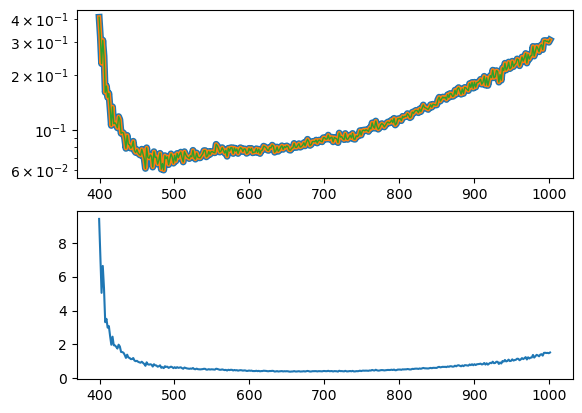

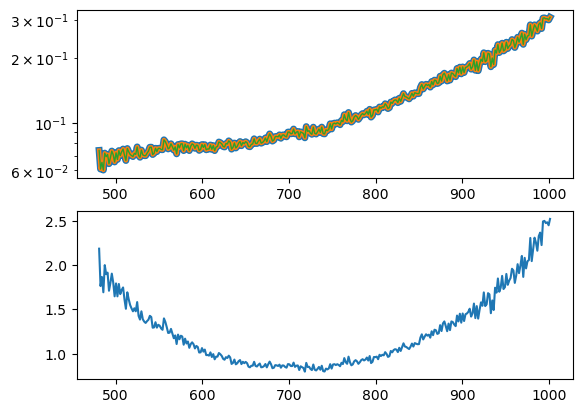

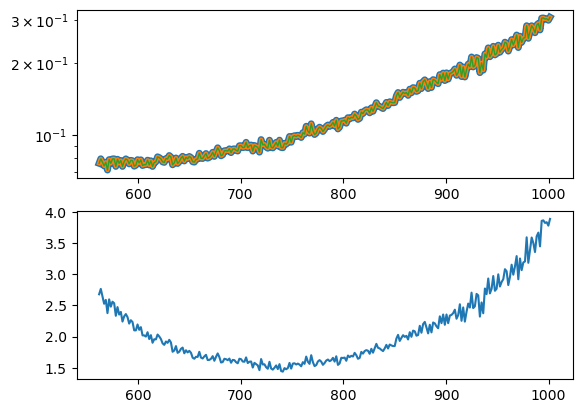

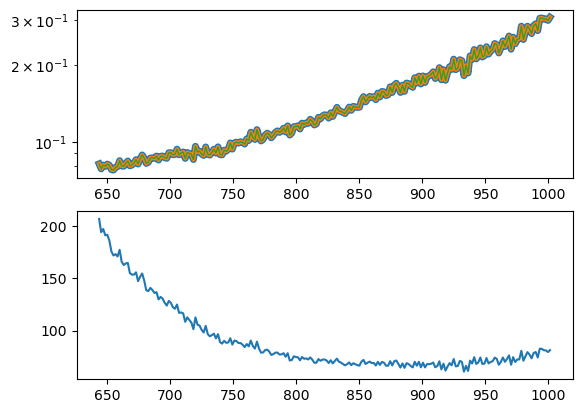

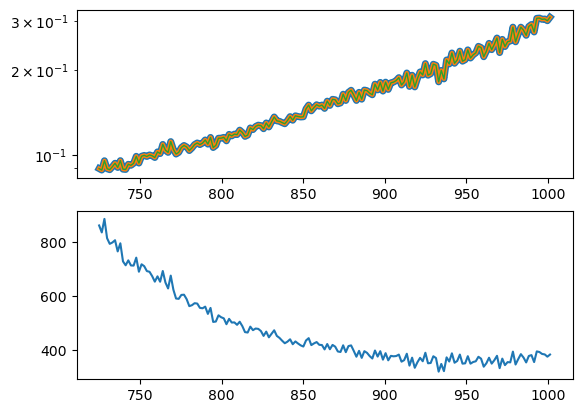

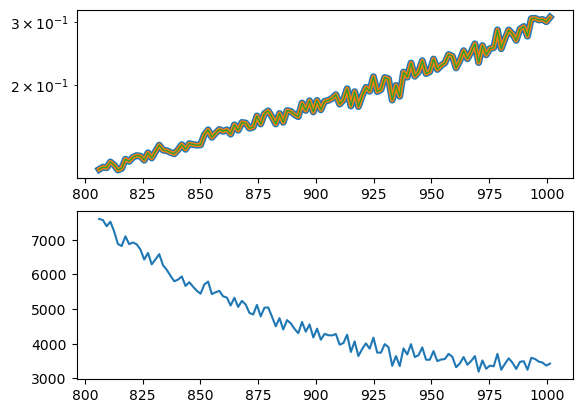

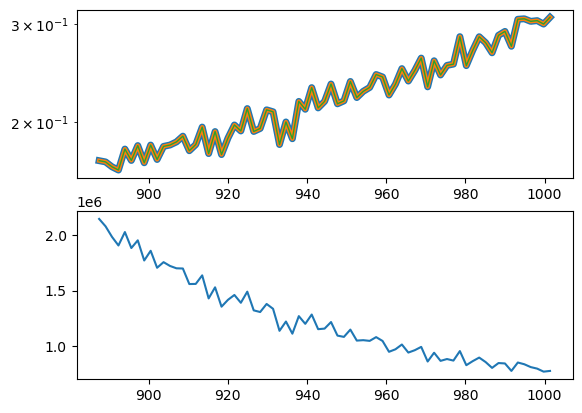

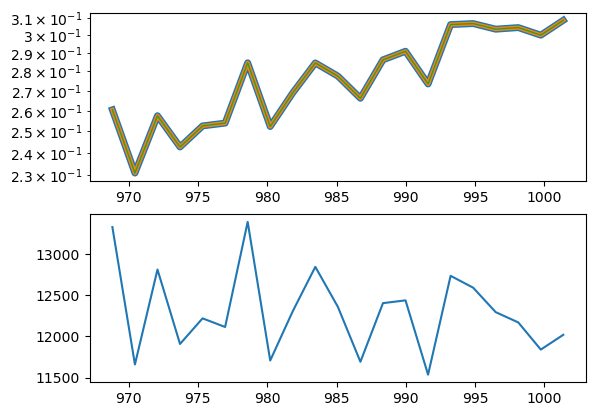

In [77]:
indices = np.arange(0, len(wavelengths_arr), 50)
ave, std = [], []
ti = time.time()
for index in indices:
    print(f"Index = {index}")
    Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][0][index:])
    ave.append(Tave), std.append(Tstd)
tf = time.time()
print(f"Time = {tf - ti} seconds")

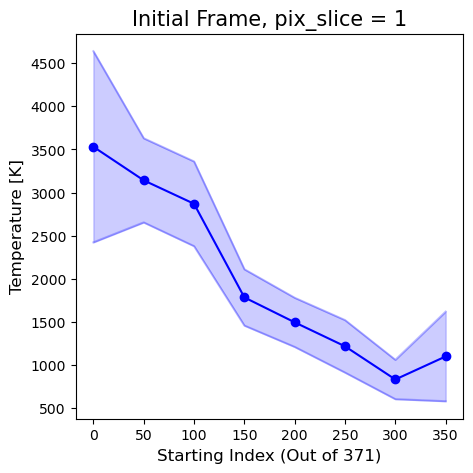

In [78]:
Ttop, Tbot = [], []
for i in range(len(ave)):
    Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

plt.figure(figsize=(5,5))
plt.title("Initial Frame, pix_slice = 1", fontsize=15)
plt.xlabel("Starting Index (Out of 371)", fontsize=12)
plt.ylabel("Temperature [K]", fontsize=12)

plt.plot(indices, ave, color="blue")
plt.scatter(indices, ave, color="blue")
plt.plot(indices, Ttop, color="blue", alpha=0.25)
# plt.scatter(indices, Ttop, color="blue")
plt.plot(indices, Tbot, color="blue", alpha=0.25)
# plt.scatter(indices, Tbot, color="blue")
plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

plt.show()

Index = 0
Average Temp. = 4589.468320412662, St. Dev. = 1540.8827111061385
Index = 50
Average Temp. = 3847.8996552953813, St. Dev. = 812.288306707042
Index = 100
Average Temp. = 3039.3702490678143, St. Dev. = 624.0006790019947
Index = 150
Average Temp. = 2677.126445733375, St. Dev. = 704.5698658066933
Index = 200
Average Temp. = 1802.7519627765416, St. Dev. = 489.86867240529097
Index = 250
Average Temp. = 1018.0474196715613, St. Dev. = 253.63040025894153
Index = 300
Average Temp. = 828.3615638199171, St. Dev. = 279.1912487045707
Index = 350


/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divi

Average Temp. = 2265.2177011454064, St. Dev. = 3755.8739400886693
Time = 319.1090831756592 seconds


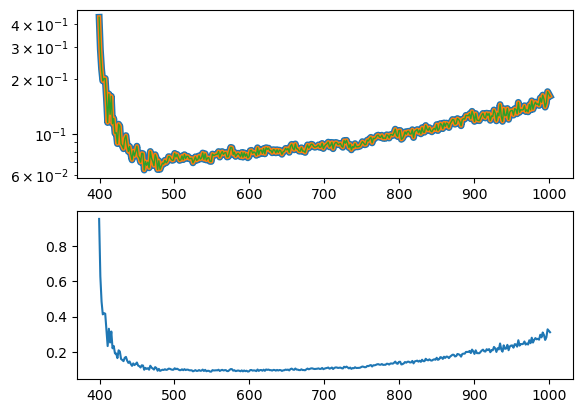

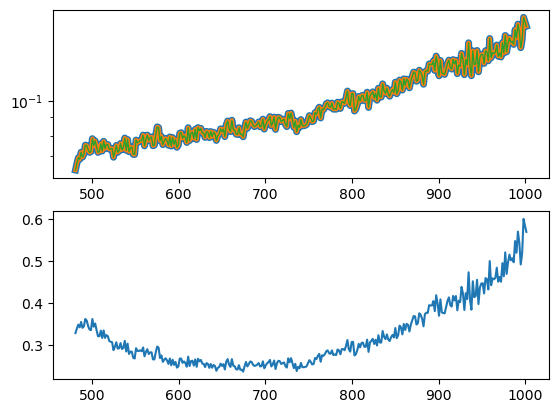

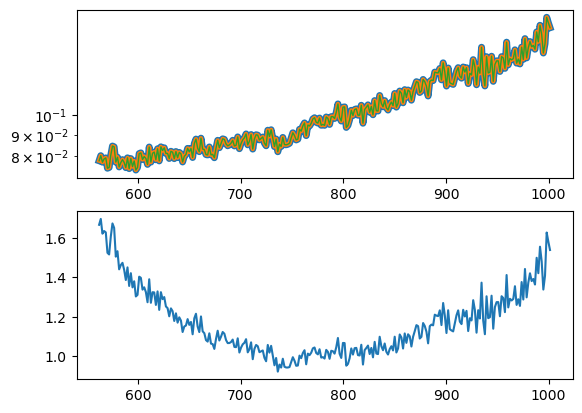

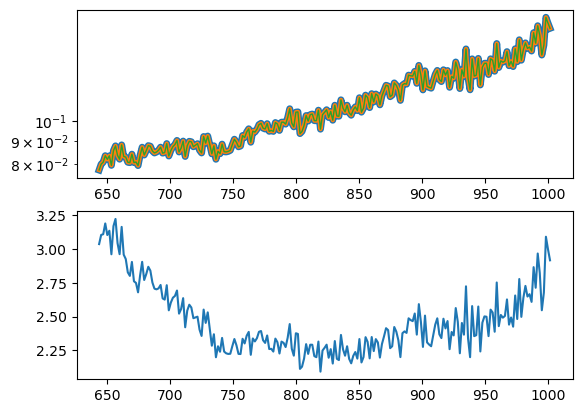

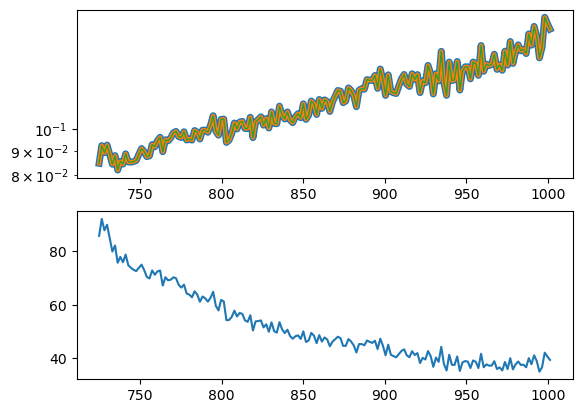

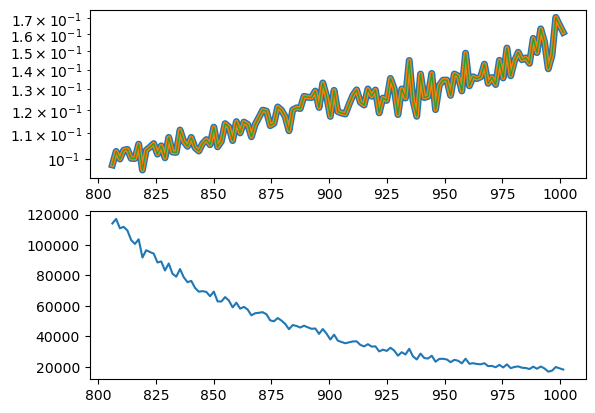

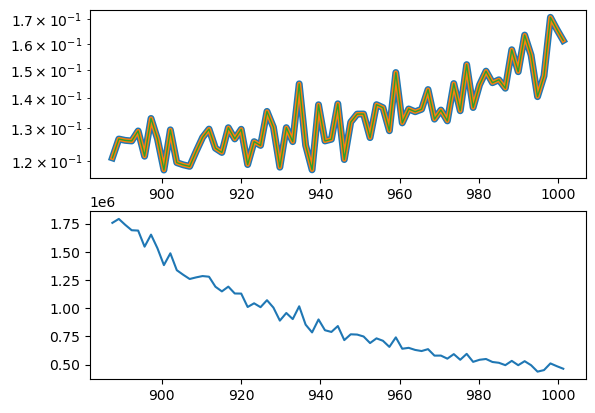

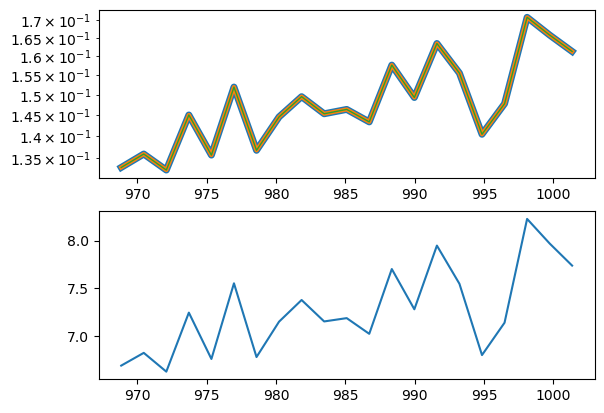

In [79]:
indices = np.arange(0, len(wavelengths_arr), 50)
ave, std = [], []
ti = time.time()
for index in indices:
    print(f"Index = {index}")
    Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][-1][index:])
    ave.append(Tave), std.append(Tstd)
tf = time.time()
print(f"Time = {tf - ti} seconds")

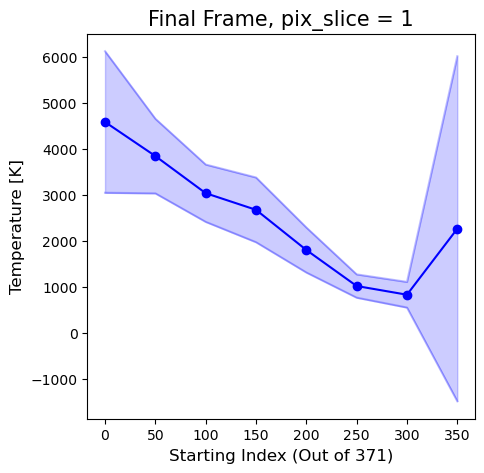

In [80]:
Ttop, Tbot = [], []
for i in range(len(ave)):
    Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

plt.figure(figsize=(5,5))
plt.title("Final Frame, pix_slice = 1", fontsize=15)
plt.xlabel("Starting Index (Out of 371)", fontsize=12)
plt.ylabel("Temperature [K]", fontsize=12)

plt.plot(indices, ave, color="blue")
plt.scatter(indices, ave, color="blue")
plt.plot(indices, Ttop, color="blue", alpha=0.25)
# plt.scatter(indices, Ttop, color="blue")
plt.plot(indices, Tbot, color="blue", alpha=0.25)
# plt.scatter(indices, Tbot, color="blue")
plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

plt.show()

It is strange that the temperature predictions aren't able to identify that the rod cools down from the initial frame to the final frame.

These plots make me think that there are some artifacts in the spectrum through the visible range that are making the spectrum resemble higher temperature than it is. One thing I would like to try is getting the spectrum for a temperature at which the peak wavelengths is within the camera's range to see if this is consistent.